<h1> Using Labeled Data to Train a Network, Use The Network to Label New Videos, and Create Trajectories </h1> 
<p> Use another notebook create a project, extract frames, and label training/testing data </p>

# DLC with docker
This notebook illustrates how to use the Docker container to:
- train a network
- evaluate a network
- analyze a novel video

many of the functions have additional parameters / complexity, see the DLC docs for more inf on each.

This assumes you already have a project folder with labeled data! 


## info about the Docker Environment:
Docker is essentially a better alternative to virtual machines. It is able to containerize applications in a way that keeps them seperate the OS and other software. 

For tensorflow / deeplab cut, docker is critical for two reasons. 
- It 'claims' the GPU, making it closed for use by other processes.
- It queries the GPU properly, in some cases tf (and the python kernal itself) does not know how to properly communincate with the GPU on windows systems.

In [1]:
# make sure you graphic driver is accessable
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:32_Central_Daylight_Time_2017
Cuda compilation tools, release 9.0, V9.0.176


In [2]:
# check the tensorflow version
import tensorflow as tf
tf.__version__

'1.14.0'

<h1> The following is very important as it allow the current GPU process to grow dynamically </h1>
Without this option tf will likely run out of VRAM when trying to update the weight tensor. In theory, these options could cause the GPU to run out of memory entirely, but there is no other way to allow training to complete successfully. 

In [3]:
#allow video memory growth as network expands to avoid convolutional network errors
TF_FORCE_GPU_ALLOW_GROWTH = True
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [4]:
#let's make sure we see a GPU:
#tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13412702529428703121, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6586089472
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11136331508361630618
 physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:41:00.0, compute capability: 7.5", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6586089472
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10144726178196130434
 physical_device_desc: "device: 1, name: GeForce RTX 2080, pci bus id: 0000:81:00.0, compute capability: 7.5"]

## Start here for training DeepLabCut and analyzing new videos!
<p><br>If the first imports fail, there is again - sadly - an issue with you enviroment. Make sure all packages beside DLC are installed via conda. </p> 

In [5]:
#GUIs don't work on in Docker (or the cloud), so label your data locally on your computer! 
#This notebook is for you to train and run video analysis!
import os

In [6]:
# now we are ready to train!
#should see version 2.0.8
import deeplabcut
deeplabcut.__version__

'2.0.8'

<h1> change to your path: </h1>
<p> this should be the same path as the one in the createDLCproject notebook. The path is the path to the config.yaml file, not the project directory itself </p> 

In [7]:
path_config_file = r'F:\MysoreData\nbk\TestDLC\3DTest\Cam2_3dTest-spencer loggia-2019-10-27\config.yaml' #change to yours!

## Create a training dataset
This function generates the training data information for DeepCut (which requires a mat file) based on the pandas dataframes that hold label information. The user can set the fraction of the training set size (from all labeled image in the hd5 file) in the config.yaml file. While creating the dataset, the user can create multiple shuffles. 

After running this script the training dataset is created and saved in the project directory under the subdirectory **'training-datasets'**

This function also creates new subdirectories under **dlc-models** and appends the project config.yaml file with the correct path to the training and testing pose configuration file. These files hold the parameters for training the network. Such an example file is provided with the toolbox and named as **pose_cfg.yaml**.

In [8]:
deeplabcut.create_training_dataset(path_config_file,Shuffles=[1])

F:\MysoreData\nbk\TestDLC\3DTest\Cam2_3dTest-spencer loggia-2019-10-27\training-datasets\iteration-0\UnaugmentedDataSet_Cam2_3dTestOct27  already exists!
The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!


### now go edit the pose_cfg.yaml to make display_iters: low (i.e. 10), and save_iters: 500

Now it is the time to start training the network!

## Start training
This function trains the network for a specific shuffle of the training dataset. 

In [9]:
#reset in case you started a session before...
#tf.reset_default_graph()

deeplabcut.train_network(path_config_file, shuffle=1, saveiters=1000, displayiters=10, gputouse=0)

#this will run until you stop it (CTRL+C), or hit "STOP" icon, or when it hits the end (default, 1.3M iterations). 
#Whichever you chose, you will see what looks like an error message, but it's not an error - don't worry....


Config:
{'all_joints': [[0], [1], [2]],
 'all_joints_names': ['bodypart1', 'bodypart2', 'bodypart3'],
 'batch_size': 1,
 'bottomheight': 400,
 'crop': True,
 'crop_pad': 0,
 'cropratio': 0.4,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_Cam2_3dTestOct27\\Cam2_3dTest_spencer '
            'loggia95shuffle1.mat',
 'dataset_type': 'default',
 'deterministic': False,
 'display_iters': 1000,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': 'C:\\Users\\pbs-mysorelab\\.conda\\envs\\nbkGPU\\lib\\site-packages\\deeplabcut\\pose_estimation_tensorflow\\models\\pretrained\\resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'leftwidth': 400,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref_loss_weight': 0.05,
 'locref_stdev': 7.2801,
 'log_dir': 'log',
 'max_input_size': 1500,
 'mean_pixel': [123.68, 116.779, 103.939],
 'metadataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_Cam2_3dTestOct27\\Do

Starting with standard pose-dataset loader.


W1027 13:02:58.798955 49492 deprecation.py:323] From C:\Users\pbs-mysorelab\.conda\envs\nbkGPU\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1027 13:02:58.845834 49492 deprecation.py:323] From C:\Users\pbs-mysorelab\.conda\envs\nbkGPU\lib\site-packages\deeplabcut\pose_estimation_tensorflow\nnet\losses.py:38: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W1027 13:03:14.300072 49492 deprecation.py:323] From C:\Users\pbs-mysorelab\.conda\envs\nbkGPU\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for 

Display_iters overwritten as 10
Save_iters overwritten as 1000
Training parameter:
{'stride': 8.0, 'weigh_part_predictions': False, 'weigh_negatives': False, 'fg_fraction': 0.25, 'weigh_only_present_joints': False, 'mean_pixel': [123.68, 116.779, 103.939], 'shuffle': True, 'snapshot_prefix': 'F:\\MysoreData\\nbk\\TestDLC\\3DTest\\Cam2_3dTest-spencer loggia-2019-10-27\\dlc-models\\iteration-0\\Cam2_3dTestOct27-trainset95shuffle1\\train\\snapshot', 'log_dir': 'log', 'global_scale': 0.8, 'location_refinement': True, 'locref_stdev': 7.2801, 'locref_loss_weight': 0.05, 'locref_huber_loss': True, 'optimizer': 'sgd', 'intermediate_supervision': False, 'intermediate_supervision_layer': 12, 'regularize': False, 'weight_decay': 0.0001, 'mirror': False, 'crop_pad': 0, 'scoremap_dir': 'test', 'batch_size': 1, 'dataset_type': 'default', 'deterministic': False, 'crop': True, 'cropratio': 0.4, 'minsize': 100, 'leftwidth': 400, 'rightwidth': 400, 'topheight': 400, 'bottomheight': 400, 'all_joints': [[

iteration: 10 loss: 0.2937 lr: 0.005
iteration: 20 loss: 0.0579 lr: 0.005
iteration: 30 loss: 0.0346 lr: 0.005
iteration: 40 loss: 0.0352 lr: 0.005
iteration: 50 loss: 0.0257 lr: 0.005
iteration: 60 loss: 0.0270 lr: 0.005
iteration: 70 loss: 0.0248 lr: 0.005
iteration: 80 loss: 0.0268 lr: 0.005
iteration: 90 loss: 0.0236 lr: 0.005
iteration: 100 loss: 0.0183 lr: 0.005
iteration: 110 loss: 0.0203 lr: 0.005
iteration: 120 loss: 0.0155 lr: 0.005
iteration: 130 loss: 0.0183 lr: 0.005
iteration: 140 loss: 0.0178 lr: 0.005
iteration: 150 loss: 0.0179 lr: 0.005
iteration: 160 loss: 0.0167 lr: 0.005
iteration: 170 loss: 0.0172 lr: 0.005
iteration: 180 loss: 0.0142 lr: 0.005
iteration: 190 loss: 0.0131 lr: 0.005
iteration: 200 loss: 0.0155 lr: 0.005
iteration: 210 loss: 0.0231 lr: 0.005
iteration: 220 loss: 0.0167 lr: 0.005
iteration: 230 loss: 0.0153 lr: 0.005
iteration: 240 loss: 0.0151 lr: 0.005
iteration: 250 loss: 0.0153 lr: 0.005
iteration: 260 loss: 0.0134 lr: 0.005
iteration: 270 loss: 

KeyboardInterrupt: 

### A couple tips for possible troubleshooting (1): 

if you get **permission errors** when you run this step (above), first check if the weights downloaded. As some docker containers might not have privileges for this (it can be user specific). They should be under 'init_weights' (see path in the pose_cfg.yaml file). You can enter the DOCKER in the terminal:

see more here: https://github.com/MMathisLab/Docker4DeepLabCut2.0#using-the-docker-for-training-and-video-analysis

### Troubleshooting (2): 
if it appears the training does not start (i.e. "Starting training..." does not print immediately),
then you have another session running on your GPU. Go check "nvidia-smi" and look at the process names. You can only have 1 per GPU!)

## Start evaluating
This funtion evaluates a trained model for a specific shuffle/shuffles at a particular state or all the states on the data set (images)
and stores the results as .csv file in a subdirectory under **evaluation-results**

In [10]:
deeplabcut.evaluate_network(path_config_file)

# Here you want to see a low pixel error! Of course, it can only be as good as the labeler, so be sure your labels are good!

Config:
{'all_joints': [[0], [1], [2]],
 'all_joints_names': ['bodypart1', 'bodypart2', 'bodypart3'],
 'batch_size': 1,
 'bottomheight': 400,
 'crop': True,
 'crop_pad': 0,
 'cropratio': 0.4,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_Cam2_3dTestOct27\\Cam2_3dTest_spencer '
            'loggia95shuffle1.mat',
 'dataset_type': 'default',
 'deterministic': False,
 'display_iters': 1000,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': 'C:\\Users\\pbs-mysorelab\\.conda\\envs\\nbkGPU\\lib\\site-packages\\deeplabcut\\pose_estimation_tensorflow\\models\\pretrained\\resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'leftwidth': 400,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref_loss_weight': 0.05,
 'locref_stdev': 7.2801,
 'log_dir': 'log',
 'max_input_size': 1500,
 'mean_pixel': [123.68, 116.779, 103.939],
 'metadataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_Cam2_3dTestOct27\\Do

Running  DeepCut_resnet50_Cam2_3dTestOct27shuffle1_1000  with # of trainingiterations: 1000
Analyzing data...


16it [00:08,  2.00it/s]


Done and results stored for snapshot:  snapshot-1000
Results for 1000  training iterations: 95 1 train error: 5.49 pixels. Test error: 7.21  pixels.
With pcutoff of 0.1  train error: 5.49 pixels. Test error: 7.21 pixels
Thereby, the errors are given by the average distances between the labels by DLC and the scorer.
The network is evaluated and the results are stored in the subdirectory 'evaluation_results'.
If it generalizes well, choose the best model for prediction and update the config file with the appropriate index for the 'snapshotindex'.
Use the function 'analyze_video' to make predictions on new videos.
Otherwise consider retraining the network (see DeepLabCut workflow Fig 2)


## There is an optional refinement step
- if your pixel errors are not low enough, use DLC docs on how to refine yur network!
- You will need to adjust the labels outside of DOCKER! (you can use the createDLCproject notebook) 
-  see DLC protocol instructions on how to refine your data!

## Start Analyzing videos
This function analyzes the new video. The user can choose the best model from the evaluation results and specify the correct snapshot index for the variable **snapshotindex** in the **config.yaml** file. Otherwise, by default the most recent snapshot is used to analyse the video.

The results are stored in hd5 file in the same directory where the video resides. 

In [11]:
videofile_path = [r'F:\MysoreData\nbk\TestDLC\3DTest\images\Cam2_train\camera-2-motion_01.avi'] #Enter the list of videos to analyze.
deeplabcut.analyze_videos(path_config_file,videofile_path)

Config:
{'all_joints': [[0], [1], [2]],
 'all_joints_names': ['bodypart1', 'bodypart2', 'bodypart3'],
 'batch_size': 1,
 'bottomheight': 400,
 'crop': True,
 'crop_pad': 0,
 'cropratio': 0.4,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_Cam2_3dTestOct27\\Cam2_3dTest_spencer '
            'loggia95shuffle1.mat',
 'dataset_type': 'default',
 'deterministic': False,
 'display_iters': 1000,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': 'C:\\Users\\pbs-mysorelab\\.conda\\envs\\nbkGPU\\lib\\site-packages\\deeplabcut\\pose_estimation_tensorflow\\models\\pretrained\\resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'leftwidth': 400,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref_loss_weight': 0.05,
 'locref_stdev': 7.2801,
 'log_dir': 'log',
 'max_input_size': 1500,
 'mean_pixel': [123.68, 116.779, 103.939],
 'metadataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_Cam2_3dTestOct27\\Do

Using snapshot-1000 for model F:\MysoreData\nbk\TestDLC\3DTest\Cam2_3dTest-spencer loggia-2019-10-27\dlc-models\iteration-0\Cam2_3dTestOct27-trainset95shuffle1
num_outputs =  1
Starting to analyze %  F:\MysoreData\nbk\TestDLC\3DTest\images\Cam2_train\camera-2-motion_01.avi
Loading  F:\MysoreData\nbk\TestDLC\3DTest\images\Cam2_train\camera-2-motion_01.avi
Duration of video [s]:  70.3 , recorded with  30.0 fps!
Overall # of frames:  2109  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


 58%|█████████████████████████████████████████████                                 | 1218/2109 [04:53<02:32,  5.84it/s]

Detected frames:  1204


 58%|█████████████████████████████████████████████                                 | 1218/2109 [04:55<03:36,  4.12it/s]


Saving results in F:\MysoreData\nbk\TestDLC\3DTest\images\Cam2_train...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract any outlier frames!


'DeepCut_resnet50_Cam2_3dTestOct27shuffle1_1000'

## Create labeled video
This funtion is for visualiztion purpose and can be used to create a video in .mp4 format with labels predicted by the network. This video is saved in the same directory where the original video resides. 

In [12]:
deeplabcut.create_labeled_video(path_config_file,videofile_path)

Starting %  F:\MysoreData\nbk\TestDLC\3DTest\images\Cam2_train ['F:\\MysoreData\\nbk\\TestDLC\\3DTest\\images\\Cam2_train\\camera-2-motion_01.avi']
Loading  F:\MysoreData\nbk\TestDLC\3DTest\images\Cam2_train\camera-2-motion_01.avi and data.
False 0 640 0 480
2109
Duration of video [s]:  40.13 , recorded with  30.0 fps!
Overall # of frames:  1204 with cropped frame dimensions:  640 480
Generating frames and creating video.


100%|█████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:05<00:00, 209.95it/s]


## Plot the trajectories of the analyzed videos
This function plots the trajectories of all the body parts across the entire video. Each body part is identified by a unique color.

F:\MysoreData\nbk\TestDLC\3DTest\images\Cam2_train\camera-2-motion_01.avi
Starting %  F:\MysoreData\nbk\TestDLC\3DTest\images\Cam2_train ['F:\\MysoreData\\nbk\\TestDLC\\3DTest\\images\\Cam2_train\\camera-2-motion_01.avi']
F:\MysoreData\nbk\TestDLC\3DTest\images\Cam2_train  already exists!
Loading  F:\MysoreData\nbk\TestDLC\3DTest\images\Cam2_train\camera-2-motion_01.avi and data.


<IPython.core.display.Javascript object>


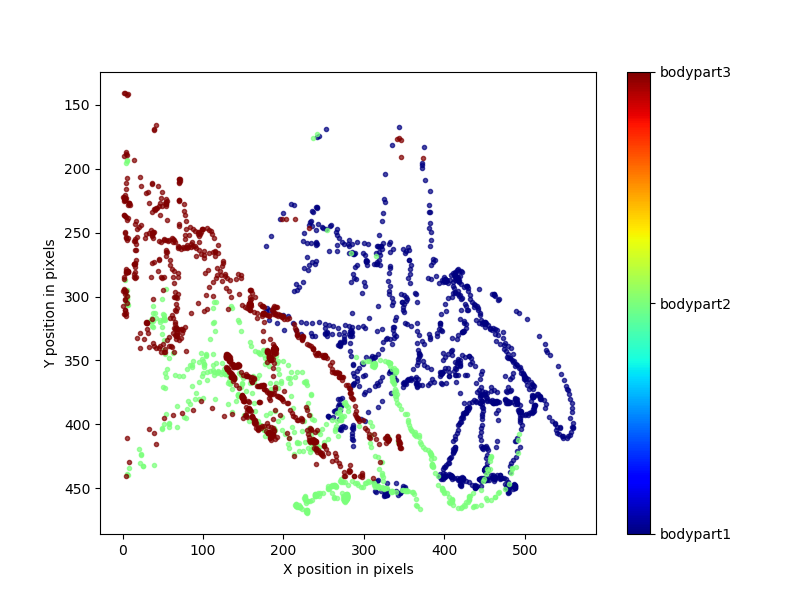

<IPython.core.display.Javascript object>


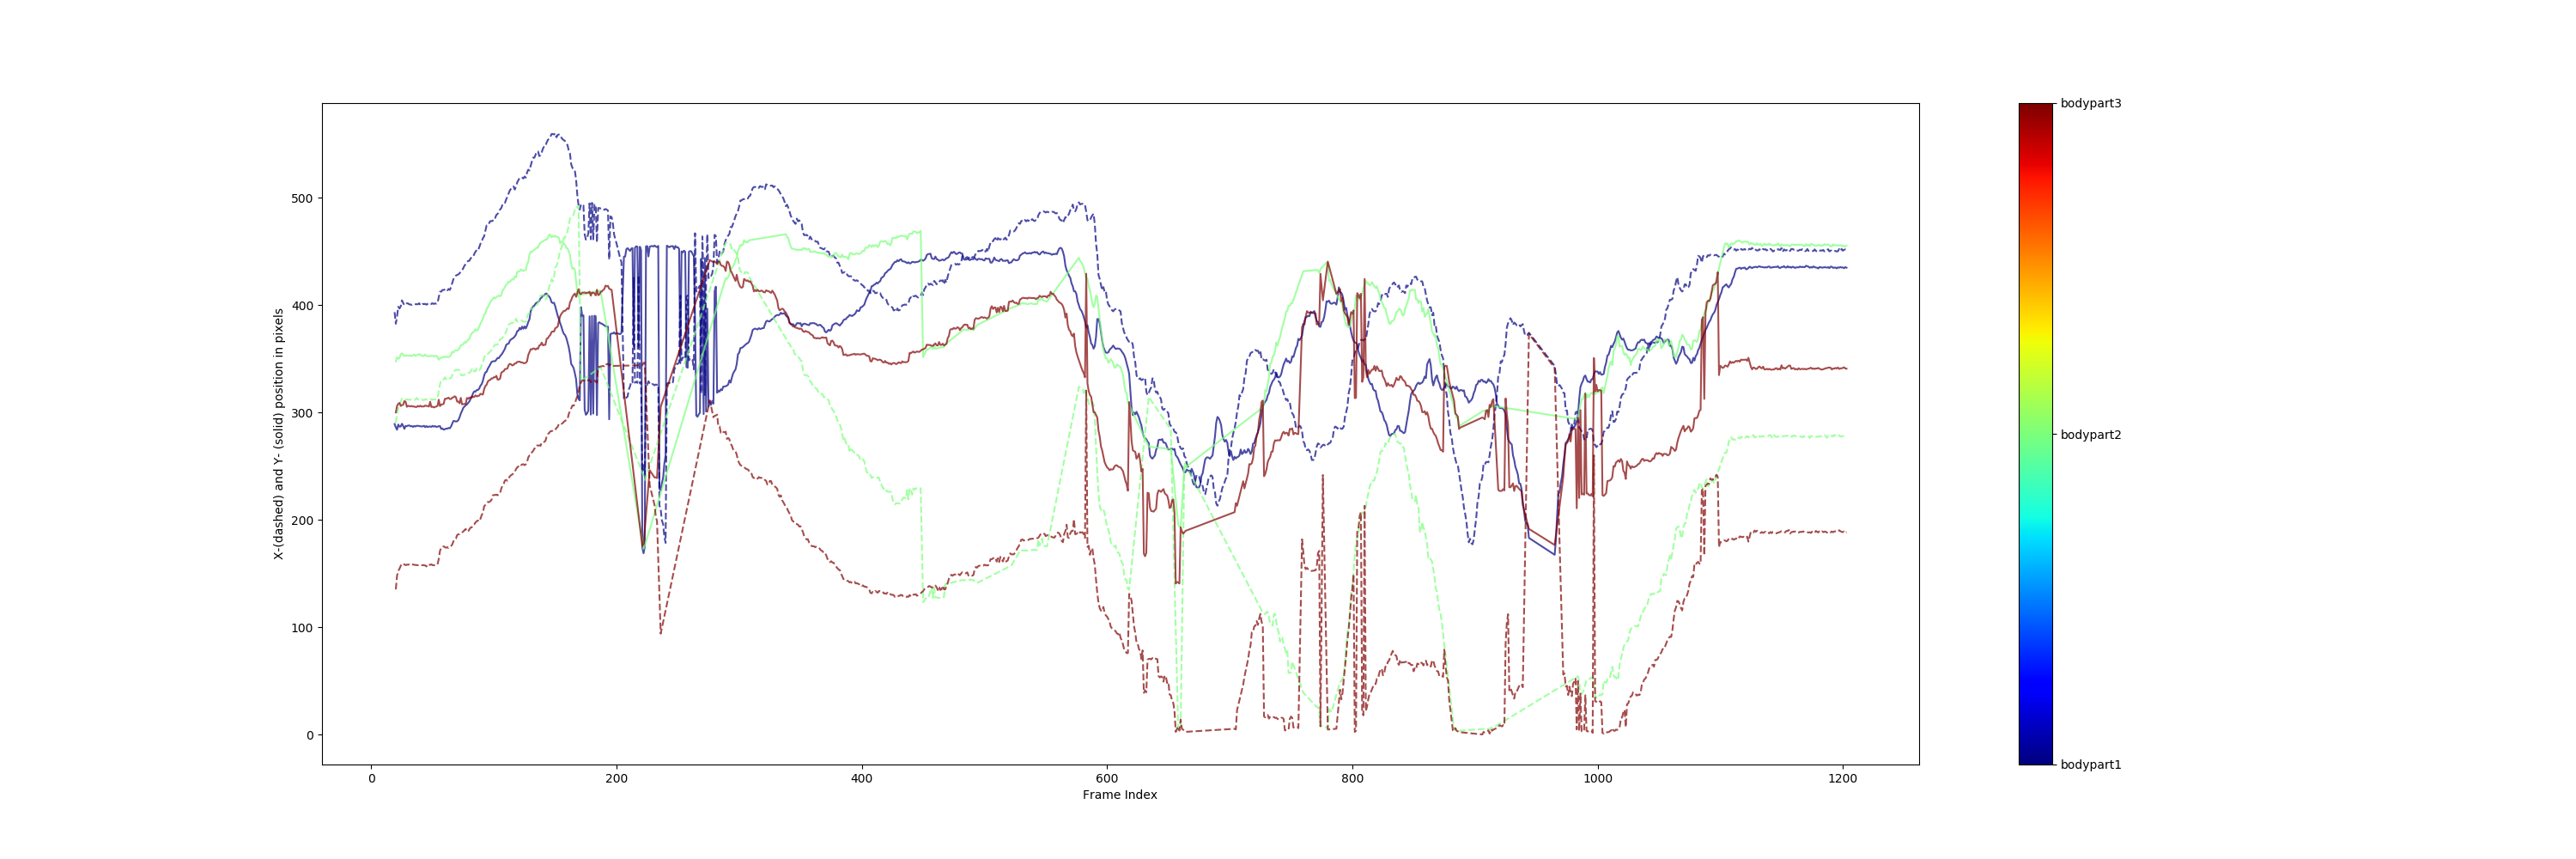

<IPython.core.display.Javascript object>


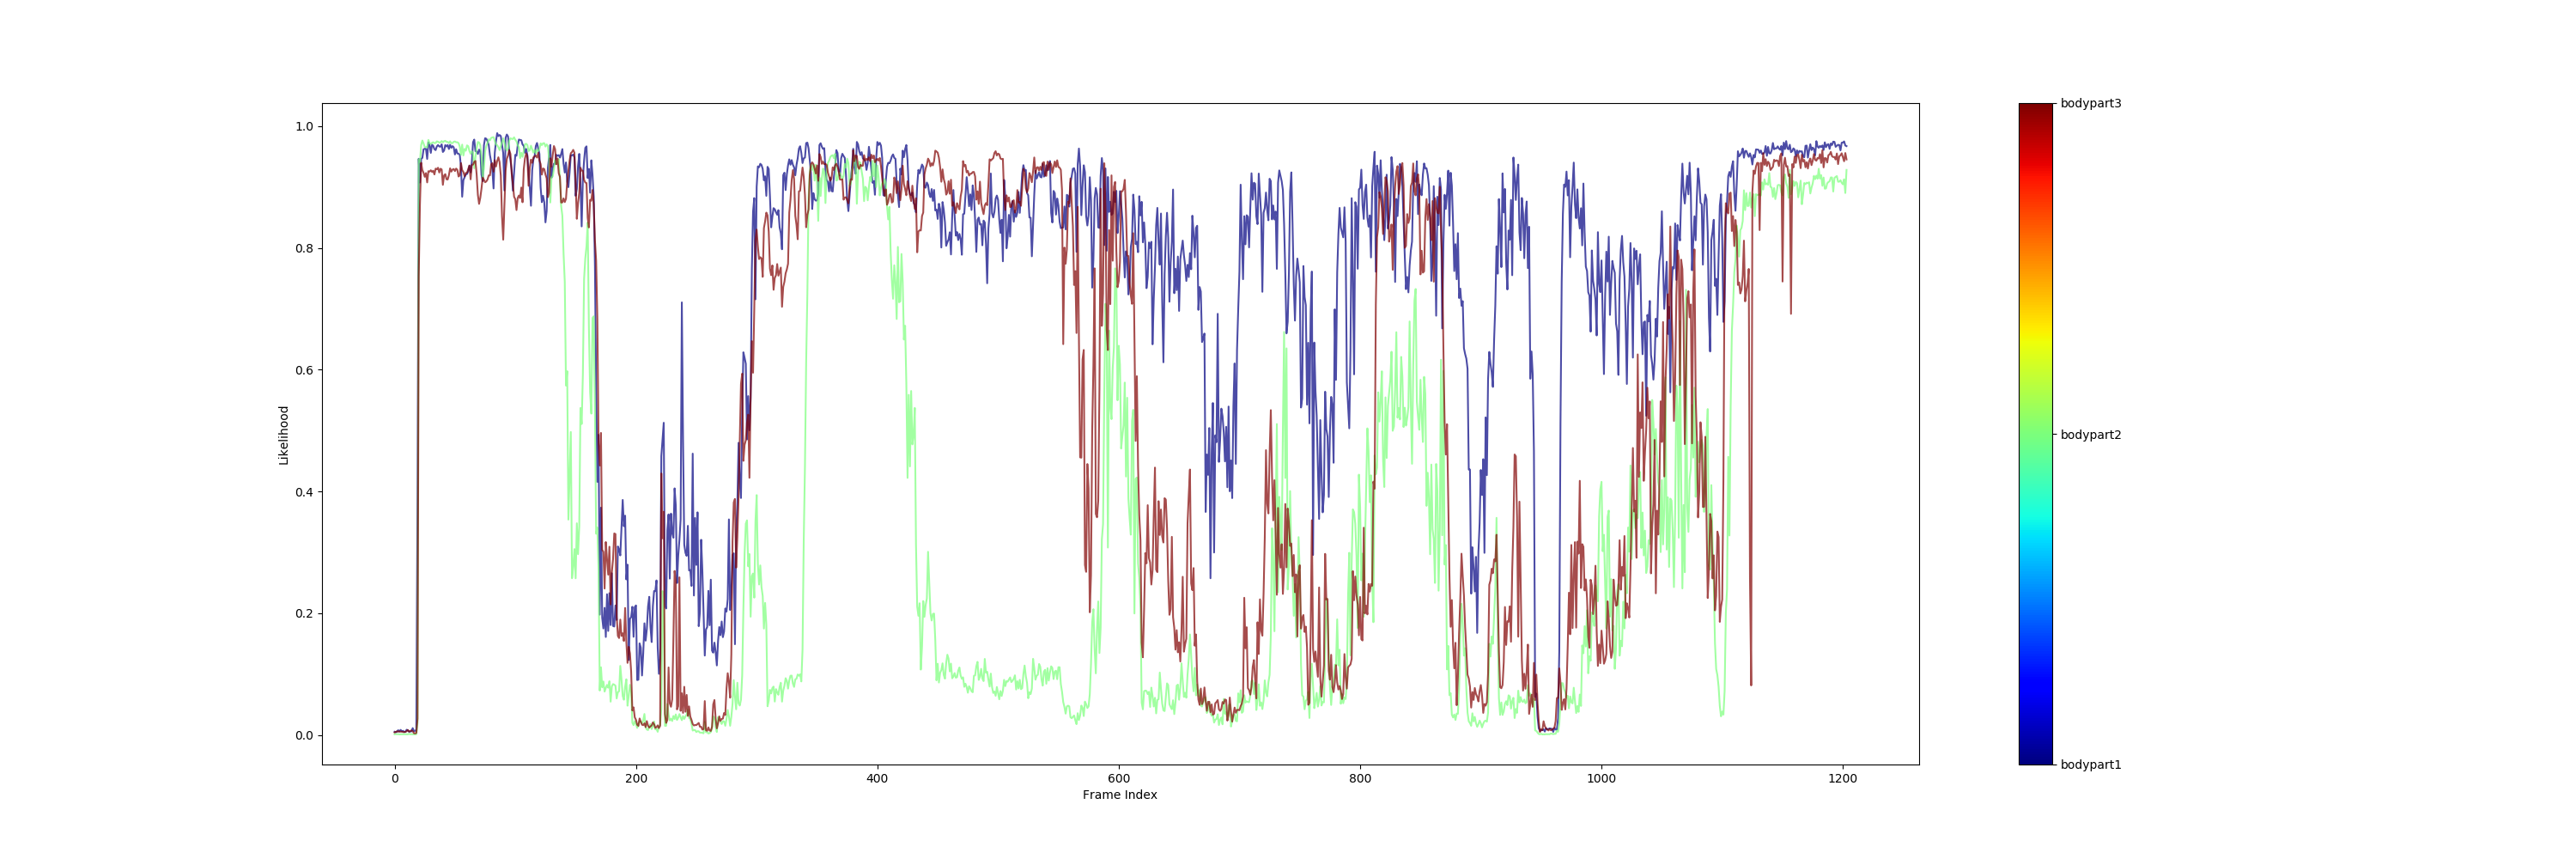

<IPython.core.display.Javascript object>


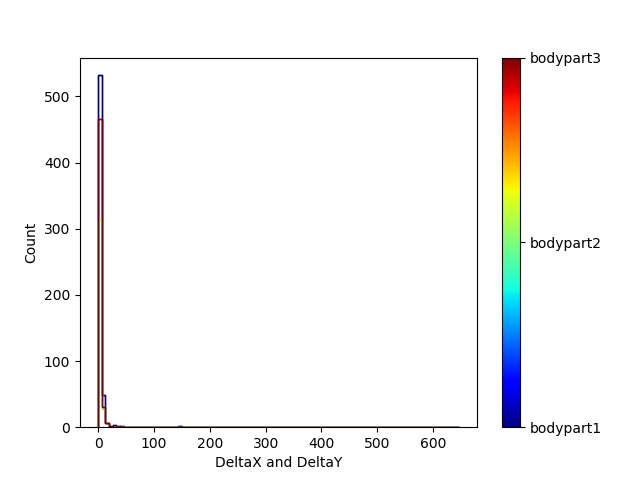

Plots created! Please check the directory "plot-poses" within the video directory


In [13]:
%matplotlib notebook 
#for making interactive plots.
#deeplabcut.plot_trajectories(path_config_file,videofile_path, plotting=True)

deeplabcut.plot_trajectories(path_config_file,videofile_path,showfigures=True)